In [13]:
#importando pacotes essenciais

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Neste exercício, vamos trabalhar com a série de temperatura mínima diária referente à
cidade de Melbourne, Austrália, no período de 1981 a 1990. As observações estão em
graus Celsius e há 3650 amostras no total. Os dados são creditados ao Australian
Bureau of Meteorology. 

In [ ]:
#lendo os dados do arquivo csv com o pandas
dataset = pd.read_csv('daily-minimum-temperatures.csv')

In [69]:
#mostrando os ultimos registros
dataset.tail(5)

,Date,Temp
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
3649,1990-12-31,13.0


In [7]:
#mostrando os primeiros registros
dataset.shape


(3650, 2)

In [26]:
#cria um array numpy com o mesmo shape do pandas
dados = np.ndarray(dataset.shape)
type(dados)

numpy.ndarray

In [29]:
#converte os dados em pandas para numpy
dados = dataset.values
dados.shape

(3650, 2)

In [50]:
#coluna 1
dados[:,[0]]

array([['1981-01-01'],
       ['1981-01-02'],
       ['1981-01-03'],
       ...,
       ['1990-12-29'],
       ['1990-12-30'],
       ['1990-12-31']], dtype=object)

In [49]:
#coluna 2
dados[:,[1]]

array([[20.7],
       [17.9],
       [18.8],
       ...,
       [13.5],
       [15.7],
       [13.0]], dtype=object)

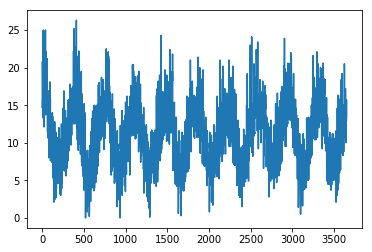

<Figure size 1440x720 with 0 Axes>

In [55]:
#grafico dos dados
plt.plot(dados[:,[1]])
fig = plt.figure(figsize=(20, 10))
plt.show()

In [67]:
#dados sobre a temperatuda
np.mean(dados[:,[1]])

11.177753424657539

In [ ]:
#dividindo o dataset em treino e teste
#dataset de testes sera o ultimo ano, 1990
#separando os ultimos 365 dados

In [75]:
dados.shape

(3650, 2)

In [76]:
3650 - 365

3285

In [77]:
#novo array que recebe as ultimas 365 linhas
dados_teste = dados[3285:]

In [80]:
dados_teste.shape

(365, 2)

In [83]:
#removendo as ultimas 365 linhas do array de treino
dados = dados[:-365, :]

In [85]:
dados.shape, dados_teste.shape

((3285, 2), (365, 2))

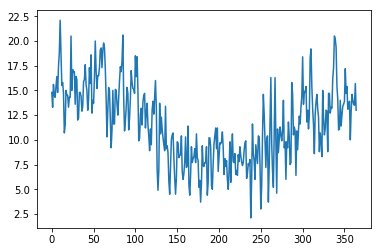

In [87]:
plt.plot(dados_teste[:,[1]])
plt.show()

In [16]:
#validacao cruzada
#Além disso, utilize um esquema de validação cruzada do tipo
#k-fold para selecionar o melhor valor do hiperparâmetro





' \nvalidacao cruzada\nAlém disso, utilize um esquema de validação cruzada do tipo\nk-fold para selecionar o melhor valor do hiperparâmetro\n'